['a' 'b' 'c' ... 'A' 'B' 'C']
false positive rate: 0.01
true positive rate 0.01
nubmer of patient samples 5329


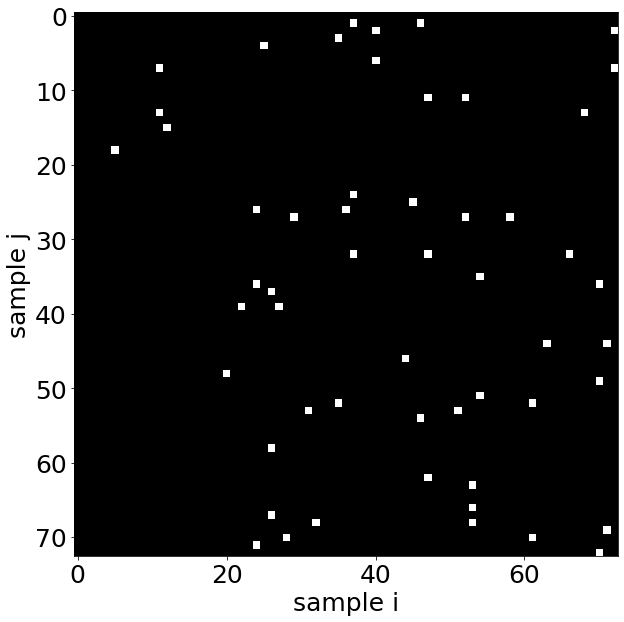

In [716]:
import numpy as np
import random
import matplotlib.pyplot as plt
import uuid
from itertools import combinations
import string
### initialize test pool ###

plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 
plt.rcParams.update({'font.size': 25})


true_positive_rate = 0.1

global false_negative_rate
global false_positive_rate


false_positive_rate = 0.01
true_positive_rate = 0.01
patient_samples = int(np.sqrt(5329))**2


gtp_array = np.zeros((patient_samples),uuid.UUID)
small_codes = np.zeros((patient_samples),str)
grand_test_pool = np.zeros((patient_samples))
ids_grand_pool = np.zeros((patient_samples),uuid.UUID)
pool_dictionary = {}


true_positives = 0
positive_patients= []
# positive_patients = random.choices(range(0,patient_samples),k=int(true_positive_rate*patient_samples))
for i in range(0,patient_samples):
    ID = uuid.uuid4()
    ids_grand_pool[i] = ID
    gtp_array[i] = ID
    small_codes[i] = string.printable[(10+i)%100]
    if random.random() <= true_positive_rate:
        true_positives += 1
        grand_test_pool[i] = 1
        pool_dictionary[ID] =1
        positive_patients.append(i)
    else:
        pool_dictionary[ID] =0

plt.figure(figsize=(10,10))
plt.xlabel("sample i")
plt.ylabel("sample j")
plt.imshow(np.reshape(grand_test_pool,[int(np.sqrt(len(grand_test_pool))),int(np.sqrt(len(grand_test_pool)))]),cmap="Greys_r")
true_negatives = patient_samples - true_positives

print(small_codes)
print("false positive rate:", false_positive_rate)
print("true positive rate",true_positive_rate)
print("nubmer of patient samples",patient_samples)

# proposed penalty for dilution
false negative probability of a single, undiluted sample : $p_-$

corrected false negative after dilution: 

# $p_-^{diluted} = p_- (1 + \frac{m_{pools}}{n_{samples}})^h $

where $h$ is a scaling constant that depends on qPCR sensitivity

In [727]:
import math
#guess an appropriate pool size - this should later be optimized      
#pool_size = int(np.sqrt(patient_samples))

#the nubmer of pools is the number of tests - 
#let's try to make some gains and see how good the accuracy still is
max_pools = 384
# min_pool_size = patient_samples/max_pools
# print("minimum pool size for non-overlapping but complete sample coverage", min_pool_size)
# pool_size = math.ceil(min_pool_size)*5
# print("target size: ", pool_size)
# for i in range(0, 100):
#     if patient_samples%(pool_size+i) == 0:
#         pool_size = pool_size+i
#         print("final pool size considering even division of chapters ", pool_size)
#         break
pool_size = int(np.sqrt(patient_samples))
       
        
 

number_of_pools = 0

#initialize pools 
pools = []
pools_to_transpose = []
final_pools = []
small_code_pools = []
for i in range(0, len(ids_grand_pool), pool_size):
    pools.append(list(ids_grand_pool[i:i+pool_size]))
    small_code_pools.append( ''.join((small_codes[i:i+pool_size])))
    
    final_pools.append(list(ids_grand_pool[i:i+pool_size]))
    pools_to_transpose.append(list(ids_grand_pool[i:i+pool_size]))
    
for pool in list(np.array(pools_to_transpose).transpose()):
    final_pools.append(list(pool))   
print("first chapter size: ", len(pools))      
print("traposed chapter size: ", len(pools_to_transpose))      
# combinatorial pool choice - try to maximize diversity
number_of_pools += len(pools)
chapter_size = len(pools)
print("chapter_size: ",chapter_size)
print(max_pools)
chapter = 0
# print(small_code_pools)
while number_of_pools < max_pools:
    for page in range(0,chapter_size):
        if number_of_pools >= max_pools: 
            break
        next_pool = []
        small_code_next_pool = ""
        for item in range(0,pool_size):
            next_pool.append(pools[chapter_size*chapter+(page+item)%chapter_size][item])
            small_code_next_pool += small_code_pools[chapter_size*chapter+(page+item)%chapter_size][item]
#         print(chapter, page, item, small_code_next_pool)
        pools.append(next_pool)
        small_code_pools.append(small_code_next_pool)
        final_pools.append(next_pool)
        number_of_pools += 1
        
    chapter += 1
print("middle chapters of pools", len(final_pools))    
base_false_negative_rate = 0.01
false_negative_rate = base_false_negative_rate*(1 + number_of_pools/patient_samples)**0

# pools = final_pools

# for pool in list(np.array(pools_to_transpose).transpose()):
#     pools.append(list(pool))  
# print("last chapter of pools", len(pools))    


print("number of pools: ", len(pools))    
print("pool size:", pool_size)
print("dilution-dependent false negative rate", false_negative_rate)

first chapter size:  73
traposed chapter size:  73
chapter_size:  73
384
middle chapters of pools 457
number of pools:  384
pool size: 73
dilution-dependent false negative rate 0.01


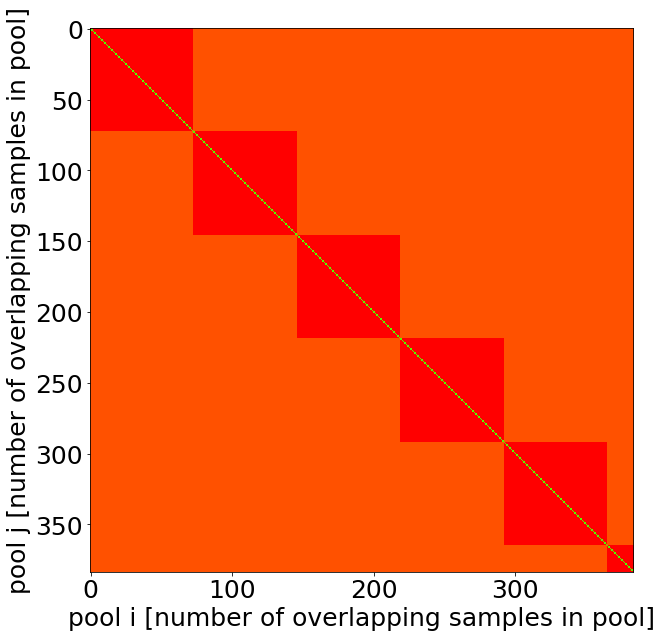

In [728]:
#check the extent of overlap between our pools
check_intersections = np.zeros((max_pools,max_pools))
for i in range(0, max_pools):
    for j in range(0, max_pools):
        check_intersections[i,j] = len(list(set(pools[i]) & set(pools[j])))
#         if check_intersections[i, j] > 1:
#             print(small_code_pools[i], small_code_pools[j],i,j)
#             print(set(small_code_pools[i]))
#             print(set(pools[i]))
            
#             print(set(small_code_pools[j]))
#             print(set(pools[j]), "\n \n \n")
# #             print(len(list(set(pools[i]) & set(pools[j]))))
        
plt.figure(figsize=(10,10))        
plt.imshow(check_intersections,cmap="prism")  
plt.xlabel("pool i [number of overlapping samples in pool]")
plt.ylabel("pool j [number of overlapping samples in pool]")
plt.show()
plt.close()

In [729]:
def run_test(samples, pool_dictionary):
    pool_result = 0
    false_positive = 0
    false_negative = 0
    for ID in samples:
        if pool_dictionary[ID] == 1:
            if random.random() < false_negative_rate:
                false_negative = 1
            else:
                pool_result = 1
        else:
            if random.random() < false_positive_rate:
                pool_result = 1 
                false_positive = 1
        if pool_result == 1 and false_negative == 1:
            false_negative = 0 #silent false negative since some other sample tested positive in the pool
    return pool_result, false_negative, false_positive


# conduct the tests now on each pool - sort them into negative and positive groups
positive_pools = []
negative_pools = []
for pool in pools:
    if run_test(pool, pool_dictionary)[0] == 1:
        positive_pools.append(list(pool))
    else:
        negative_pools.append(list(pool))        
        
flat_pos_pools = [val for sublist in positive_pools for val in sublist]
flat_neg_pools = [val for sublist in negative_pools for val in sublist]

false pos/ neg sample 0.19962085308056873
false neg/pos sample 0.018518518518518517
fold efficiency:  13.877604166666666 samples/test
coverage (redundancy):  pools*size / samples:  5.260273972602739 x
correctly identified rate 0.8022142991180334 correct results/sample


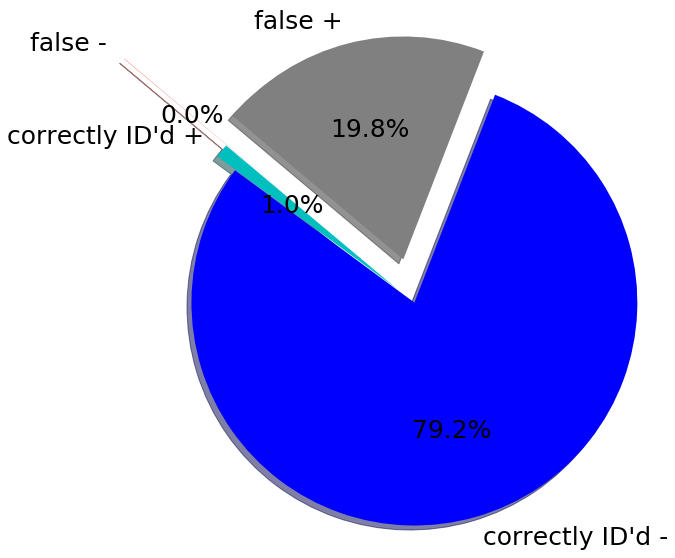

In [720]:
# assess the accuracy by comparing with the dictionary of true positives
errors = 0
correctly_identified = 0
correctly_identidied_positives = 0
correctly_identidied_negatives = 0
false_pos_errors = 0
false_neg_errors = 0
final_positives = list(set(flat_pos_pools) - set(flat_neg_pools))
for i in set(final_positives):
    if pool_dictionary[i] != 1:
        errors += 1
        false_pos_errors += 1
    else :
        correctly_identified += 1
        correctly_identidied_positives += 1
for i in set(flat_neg_pools):
    if pool_dictionary[i] != 0:
        errors += 1
        false_neg_errors += 1
    else :
        correctly_identified += 1  
        correctly_identidied_negatives += 1
#print("errors/sample", errors/patient_samples)        
print("false pos/ neg sample", false_pos_errors/true_negatives)        
print("false neg/pos sample", false_neg_errors/true_positives)  
print("fold efficiency: ", patient_samples/number_of_pools,"samples/test")
print("coverage (redundancy):  pools*size / samples: ", (number_of_pools*pool_size)/patient_samples, "x")
print("correctly identified rate", correctly_identified/patient_samples, "correct results/sample")


sizes = [correctly_identidied_positives, correctly_identidied_negatives, false_pos_errors, false_neg_errors]
# print(np.sum(sizes))
labels = ["correctly ID'd +","correctly ID'd -","false +","false -"]
explode = (0.1, 0 , .2,.7)
plt.figure(figsize=(10,10))        
plt.pie(sizes, labels=labels, explode = explode,colors=["c","b","grey","r"],
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()
plt.close()



# sizes = [correctly_identidied_positives, false_pos_errors]
# # print(np.sum(sizes))
# labels = ["correctly identified positives","false +"]
# explode = (0.1, 0)
# plt.figure(figsize=(10,10))        
# plt.pie(sizes, labels=labels, explode = explode,colors=["b","grey"],
# autopct='%1.1f%%', shadow=True, startangle=140)
# plt.axis('equal')
# plt.show()
# plt.close()

# sizes = [correctly_identidied_negatives, false_neg_errors]
# # print(np.sum(sizes))
# labels = ["correctly identified negatives","false -"]
# explode = (0.1, 0)
# plt.figure(figsize=(10,10))        
# plt.pie(sizes, labels=labels, explode = explode,colors=["b","r"],
# autopct='%1.1f%%', shadow=True, startangle=140)
# plt.axis('equal')
# plt.show()
# plt.close()

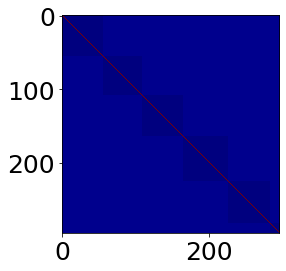

In [730]:
# show intersection between positive pools
max_pos_pools = len(positive_pools)
intersect_final = []
check_pos_intersections = np.zeros((max_pos_pools,max_pos_pools))
for i in range(0, max_pos_pools):
    for j in range(0, max_pos_pools):
        current_intersect = list(set(positive_pools[i]) & set(positive_pools[j]))
        check_pos_intersections[i,j] = len(current_intersect)
                
plt.imshow(check_pos_intersections,cmap="jet")   
plt.show()
plt.close()